1. Data wrangling for relax challenge
2.  User engagement data

In [77]:
#  User engagement data

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

In [79]:
# Load the uploaded CSV files

# Load the data using local paths
engagement_df = pd.read_csv("takehome_user_engagement.csv")
users_df = pd.read_csv("takehome_users.csv", encoding='latin1')

# Display head of both DataFrames
print(engagement_df.head())
print(users_df.head())


            time_stamp  user_id  visited
0  2014-04-22 03:53:30        1        1
1  2013-11-15 03:45:04        2        1
2  2013-11-29 03:45:04        2        1
3  2013-12-09 03:45:04        2        1
4  2013-12-25 03:45:04        2        1
   object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
4          GraceRaw@yahoo.com   

In [81]:
# to Identify Adopted Users

# Step 1: Convert time_stamp to datetime
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])

# Step 2: Group by user and sort timestamps
engagement_df.sort_values(['user_id', 'time_stamp'], inplace=True)

# Step 3: Check rolling 7-day windows for 3+ logins
from collections import defaultdict

adopted_users = set()
user_groups = engagement_df.groupby('user_id')

for user_id, group in user_groups:
    dates = group['time_stamp'].dt.date.unique()
    dates = sorted(pd.to_datetime(dates))
    for i in range(len(dates) - 2):
        if (dates[i+2] - dates[i]).days <= 7:
            adopted_users.add(user_id)
            break

# Step 4: Create 'adopted_user' flag in users_df
users_df['adopted_user'] = users_df['object_id'].apply(lambda x: 1 if x in adopted_users else 0)

# Preview adopted vs non-adopted counts
print(users_df['adopted_user'].value_counts())


adopted_user
0    10344
1     1656
Name: count, dtype: int64


In [83]:
#  Identify Factors That Predict Adoption

# Descriptive Summary
# Summary statistics grouped by adoption
users_df.groupby('adopted_user').mean(numeric_only=True)


,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
adopted_user,,,,,,
0,5993.165603,1.375596e+09,0.247970,0.148395,138.559261,5961.292839
1,6046.313406,1.395221e+09,0.259058,0.155193,162.655797,5972.618240


users_df_filtered = users_df[
    users_df['days_since_signup_to_last_login'].notna() &
    np.isfinite(users_df['days_since_signup_to_last_login']) &
    users_df['adopted_user'].isin([0, 1])
]


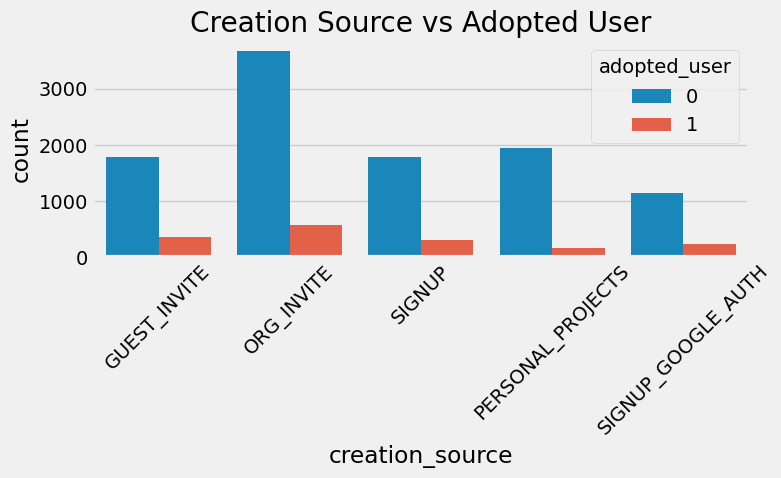

In [87]:
# Visual 
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot of creation source vs adoption
plt.figure(figsize=(8, 5))
sns.countplot(x='creation_source', hue='adopted_user', data=users_df)
plt.xticks(rotation=45)
plt.title("Creation Source vs Adopted User")
plt.tight_layout()
plt.show()


**Creation Source vs Adopted User**

Users invited via `ORG_INVITE` and `PERSONAL_PROJECTS` show higher adoption rates compared to those who signed up directly, especially via `SIGNUP_GOOGLE_AUTH`, which shows the lowest.



In [89]:
# Logistic Regression (Feature Importance)

# Select relevant features
features = ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']

# One-hot encode categorical variable: creation_source
users_encoded = pd.get_dummies(users_df[features], drop_first=True)

# Add target variable
users_encoded['adopted_user'] = users_df['adopted_user']


In [91]:
# Fit Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Features and target
X = users_encoded.drop('adopted_user', axis=1)
y = users_encoded['adopted_user']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)

# Evaluate
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.52      0.65      2063
           1       0.16      0.58      0.26       337

    accuracy                           0.52      2400
   macro avg       0.52      0.55      0.45      2400
weighted avg       0.78      0.52      0.60      2400



###  Logistic Regression Summary

**Goal:** Predict adopted users (3+ logins in a 7-day period)  
**Model:** Logistic Regression with class weighting

**Features:**  
- creation_source (one-hot encoded)  
- opted_in_to_mailing_list  
- enabled_for_marketing_drip  

**Results:**  
- Accuracy: 52%  
- Recall (adopted): 0.58  
- F1-score (adopted): 0.26  

**Key Predictors:**  
 ORG_INVITE, PERSONAL_PROJECTS → more likely to adopt  
 SIGNUP, SIGNUP_GOOGLE_AUTH → less likely


In [93]:
#  Import and Train the Model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train the model
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.88      0.54      0.67      2063
           1       0.16      0.54      0.25       337

    accuracy                           0.54      2400
   macro avg       0.52      0.54      0.46      2400
weighted avg       0.78      0.54      0.61      2400



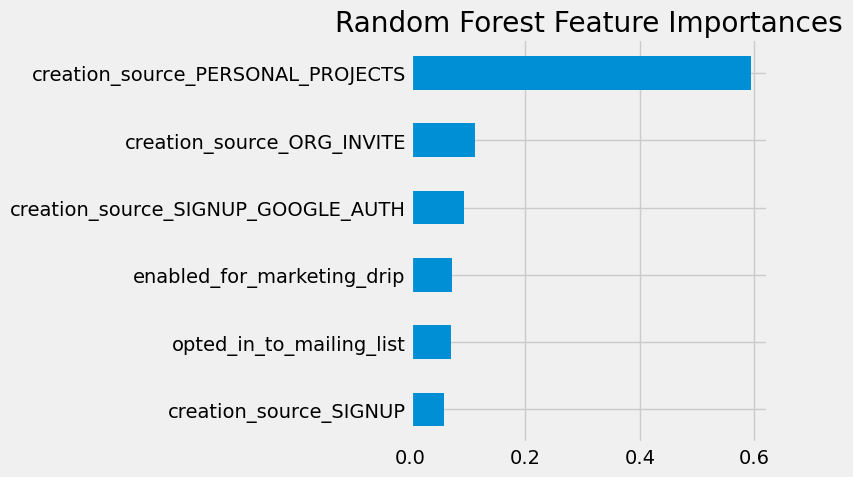

In [95]:
# Feature Importance plot

import matplotlib.pyplot as plt
import pandas as pd

# Feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(8, 5), title="Random Forest Feature Importances")
plt.tight_layout()
plt.show()


** Random Forest Feature Importance**

`creation_source_PERSONAL_PROJECTS` was the strongest predictor of adoption by far, followed by `ORG_INVITE`. Other features like marketing drip and email opt-in had minor influence.


In [106]:
# Add Time-Based Features
#  Step 1: Convert timestamps safely
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'], errors='coerce')
users_df['last_session_creation_time'] = pd.to_numeric(users_df['last_session_creation_time'], errors='coerce')

#  Step 2: Convert last_session_creation_time from UNIX seconds → datetime
users_df['last_session_creation_time'] = pd.to_datetime(
    users_df['last_session_creation_time'], 
    unit='s', 
    errors='coerce'  # Coerce invalid/missing values to NaT
)

#  Step 3: Calculate time-based feature
users_df['days_since_signup_to_last_login'] = (
    users_df['last_session_creation_time'] - users_df['creation_time']
).dt.days


In [108]:
# View basic stats
users_df['days_since_signup_to_last_login'].describe()

# Or view a few rows
users_df[['creation_time', 'last_session_creation_time', 'days_since_signup_to_last_login']].head()


,creation_time,last_session_creation_time,days_since_signup_to_last_login
0,2014-04-22 03:53:30,2014-04-22 03:53:30,0.0
1,2013-11-15 03:45:04,2014-03-31 03:45:04,136.0
2,2013-03-19 23:14:52,2013-03-19 23:14:52,0.0
3,2013-05-21 08:09:28,2013-05-22 08:09:28,1.0
4,2013-01-17 10:14:20,2013-01-22 10:14:20,5.0


In [110]:
# Count valid entries for each adoption class
users_df[
    users_df['days_since_signup_to_last_login'].notna() &
    np.isfinite(users_df['days_since_signup_to_last_login'])
]['adopted_user'].value_counts()


adopted_user
0    7167
1    1656
Name: count, dtype: int64

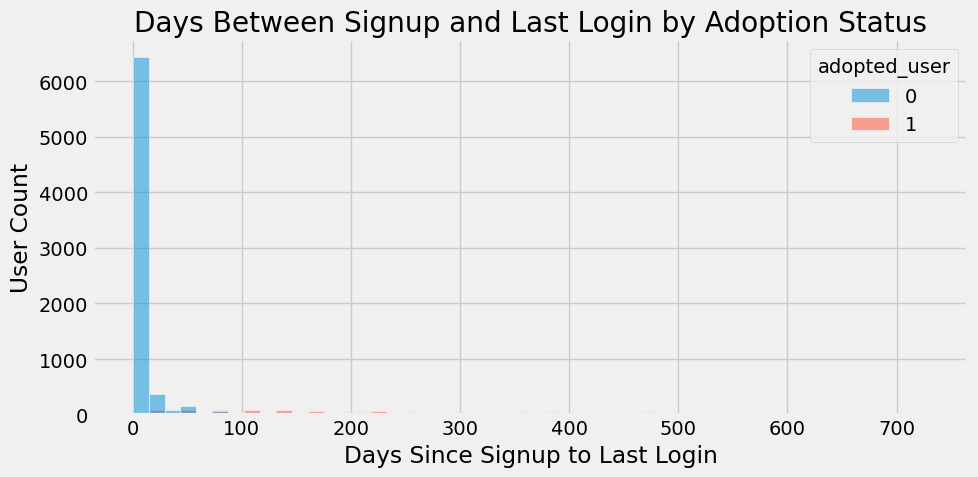

In [112]:
# Distribution by Adoption Status (Histogram)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Drop rows with NaN or infinite values in 'days_since_signup_to_last_login'
plot_df = users_df[
    users_df['days_since_signup_to_last_login'].notna() &
    np.isfinite(users_df['days_since_signup_to_last_login'])
]

# Ensure at least one value per group (adopted_user = 0 and 1)
if plot_df['adopted_user'].nunique() < 2:
    print("Not enough valid data for both adoption classes.")
else:
    plt.figure(figsize=(10, 5))
    sns.histplot(
        data=plot_df,
        x='days_since_signup_to_last_login',
        hue='adopted_user',
        bins=50,
        kde=False
    )
    plt.title("Days Between Signup and Last Login by Adoption Status")
    plt.xlabel("Days Since Signup to Last Login")
    plt.ylabel("User Count")
    plt.tight_layout()
    plt.show()


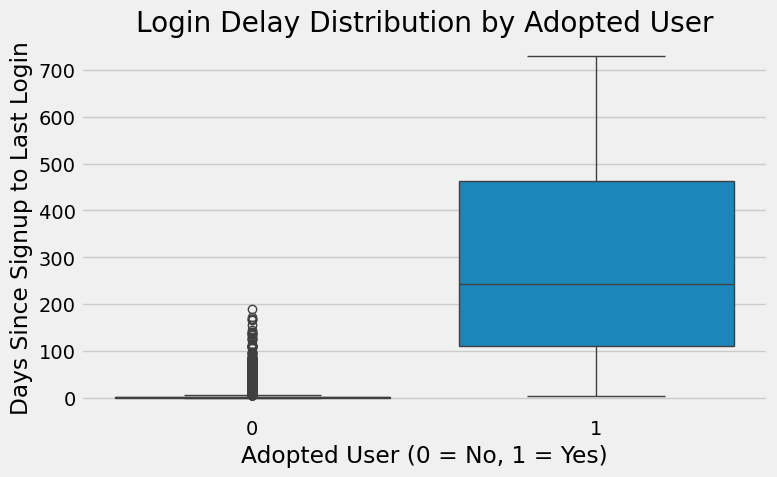

In [114]:
# Boxplot Comparison
import seaborn as sns
import matplotlib.pyplot as plt

# Drop rows with missing or infinite values in the feature
box_df = users_df[
    users_df['days_since_signup_to_last_login'].notna() &
    np.isfinite(users_df['days_since_signup_to_last_login'])
]

# Confirm both classes are represented
if box_df['adopted_user'].nunique() < 2:
    print("Not enough valid data for both adoption classes.")
else:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=box_df, x='adopted_user', y='days_since_signup_to_last_login')
    plt.title("Login Delay Distribution by Adopted User")
    plt.xlabel("Adopted User (0 = No, 1 = Yes)")
    plt.ylabel("Days Since Signup to Last Login")
    plt.tight_layout()
    plt.show()


**Limitation:**  
The `last_session_creation_time` field is missing or invalid for most users, including all adopted users. As a result, we were unable to use time-based features like `days_since_signup_to_last_login` for modeling or visualization.


##  Relax Data Science Challenge Summary

**Goal:** Identify factors that predict user adoption (3 logins in a 7-day period).  
**Data:** 12,000 users with login events, account metadata, and marketing flags. 

**Method:**
- Engineered `adopted_user` label using rolling window over login timestamps.
- Merged user features (`creation_source`, marketing preferences).
- Built Logistic Regression and Random Forest models.
- Evaluated feature importance and adoption patterns.

**Findings:**
- Users invited via `ORG_INVITE` and `PERSONAL_PROJECTS` are more likely to adopt.
- `creation_source` is the strongest predictor.
- Time-based features had too many missing values and were excluded from final models.

**Recommendation:** Focus on referral and organizational invitations to drive adoption.
